# Спринт 11 «Машинное обучение в бизнесе»

# Проект «Выбор локации для скважины»

## Навигация

1. [Описание проекта](#Описание-проекта)
1. [Описание данных](#Описание-данных)
1. [Загрузка и подготовка данных](#Загрузка-и-подготовка-данных)
1. [Обучение и проверка модели](#Обучение-и-проверка-модели)
1. [Подготовка к расчёту прибыли](#Подготовка-к-расчёту-прибыли)
1. [Расчёт прибыли и рисков](#Расчёт-прибыли-и-рисков )
1. [Общий вывод](#Общий-вывод)

## Описание проекта

[к навигации](#Навигация)

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Также нужно проанализировать возможную прибыль и риски техникой _Bootstrap_.

## Описание данных

[к навигации](#Навигация)

Данные геологоразведки трёх регионов находятся в файлах: 
- `geo_data_0.csv`
- `geo_data_1.csv`
- `geo_data_2.csv`

**Поля в данных:**
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

In [1]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
RANDOM_STATE = 42

## Загрузка и подготовка данных

[к навигации](#Навигация)

In [3]:
geo_data_0 = pd.read_csv(os.path.join('..', 'datasets', 'geo_data_0.csv'), index_col='id')
geo_data_1 = pd.read_csv(os.path.join('..', 'datasets', 'geo_data_1.csv'), index_col='id')
geo_data_2 = pd.read_csv(os.path.join('..', 'datasets', 'geo_data_2.csv'), index_col='id')
geo_data_0.head()

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


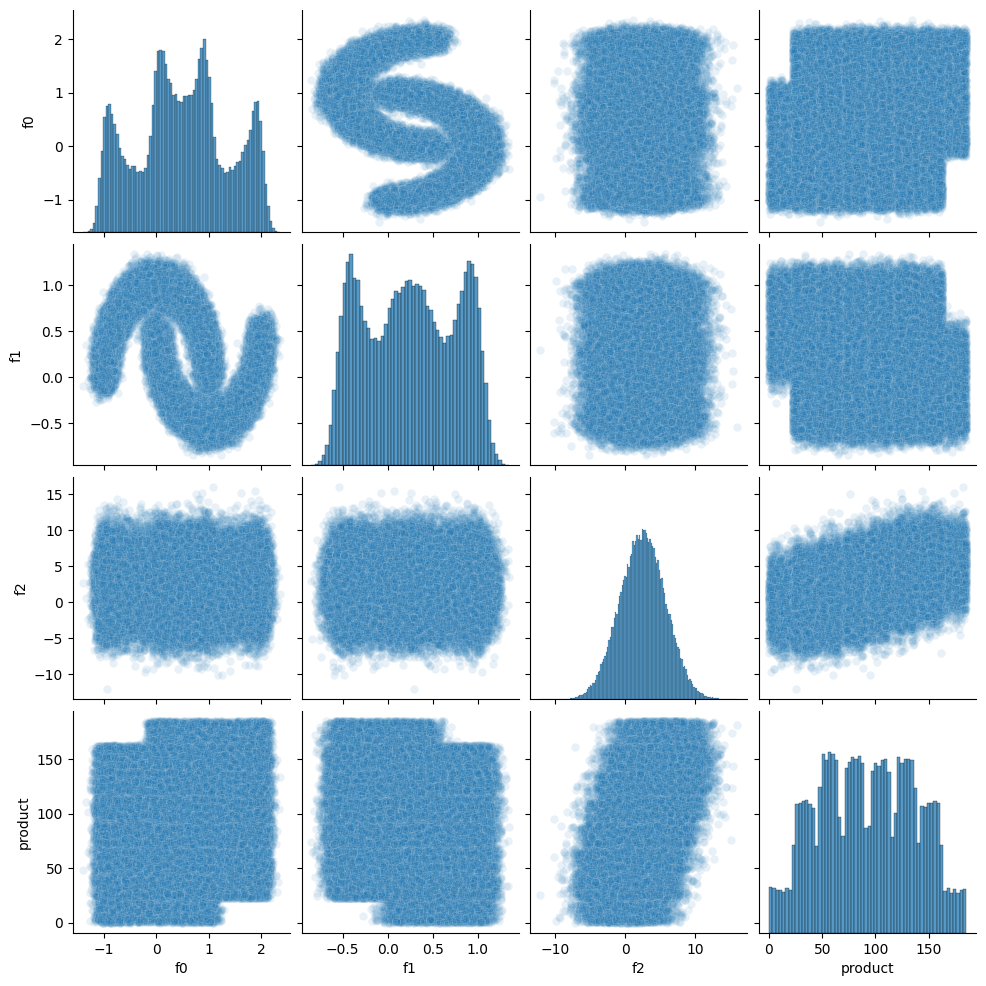

In [5]:
sns.pairplot(geo_data_0, plot_kws={'alpha': 0.1})

---

In [6]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


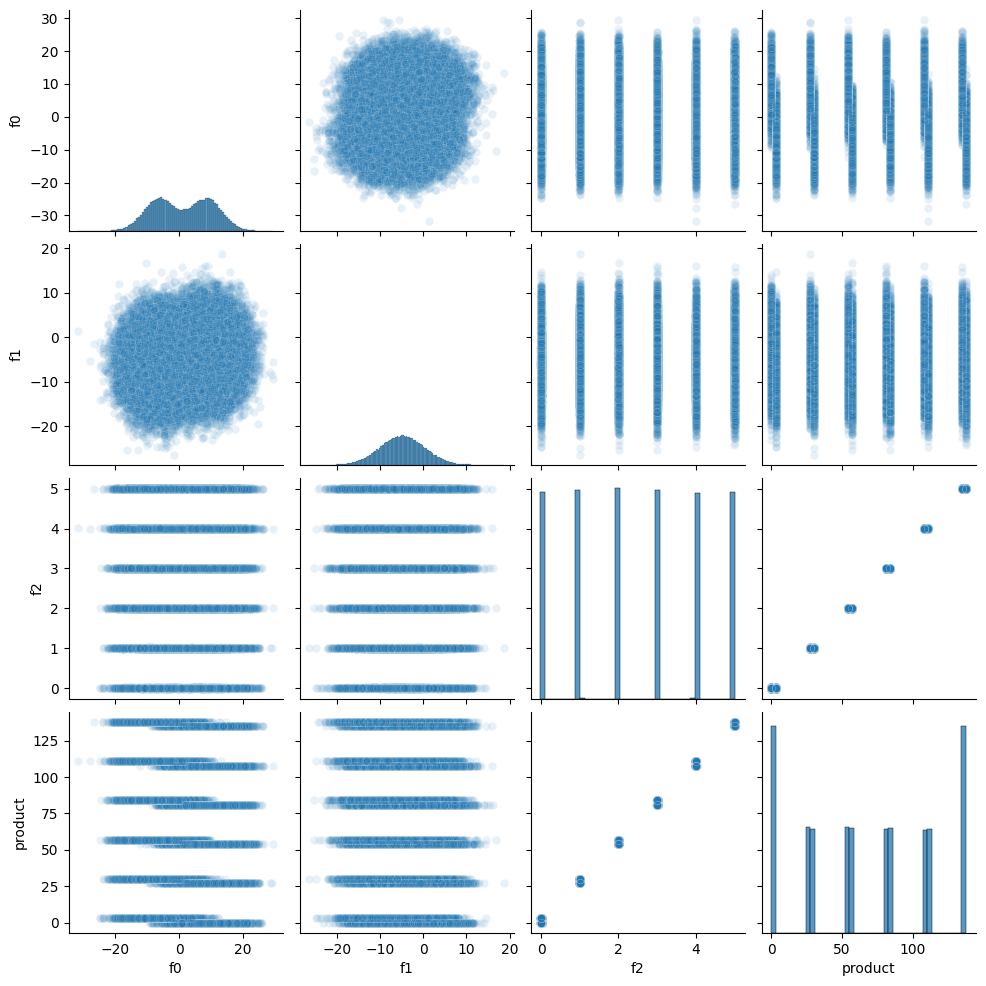

In [7]:
sns.pairplot(geo_data_1, plot_kws={'alpha': 0.1})

---

In [8]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


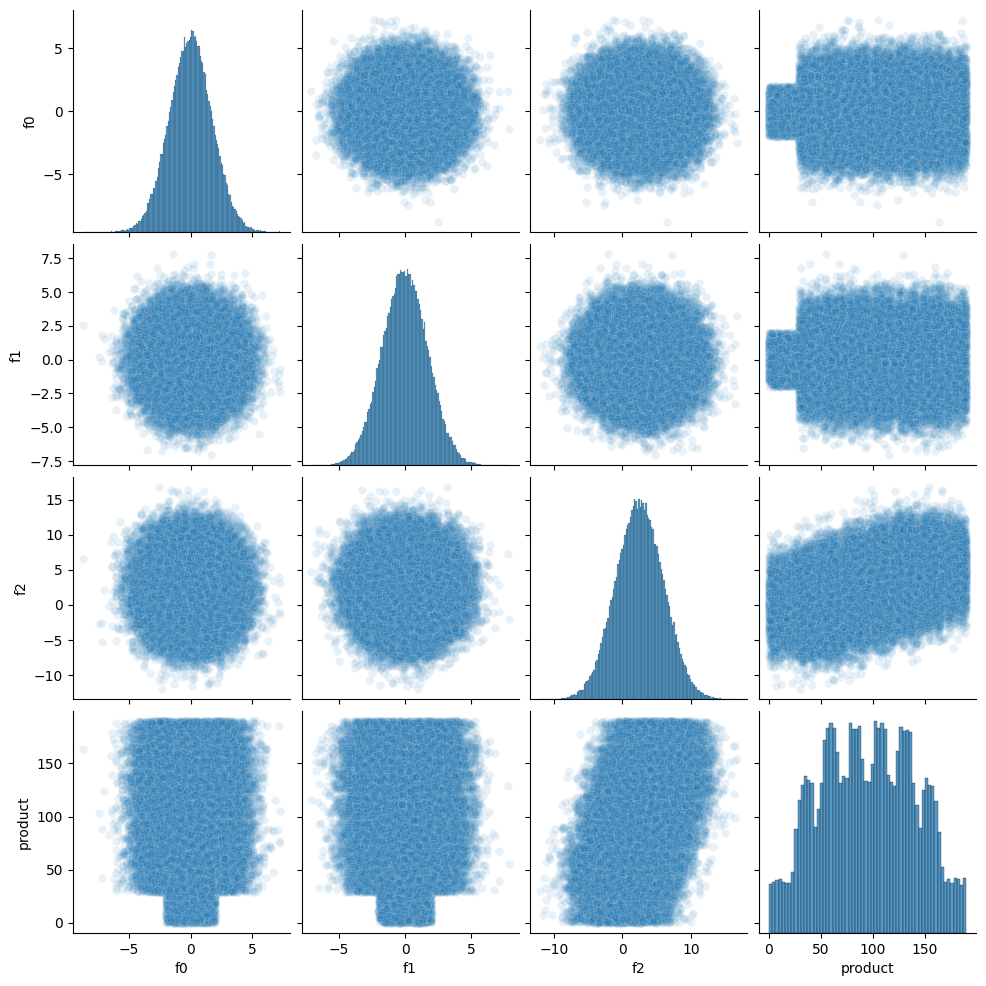

In [9]:
sns.pairplot(geo_data_2, plot_kws={'alpha': 0.1})

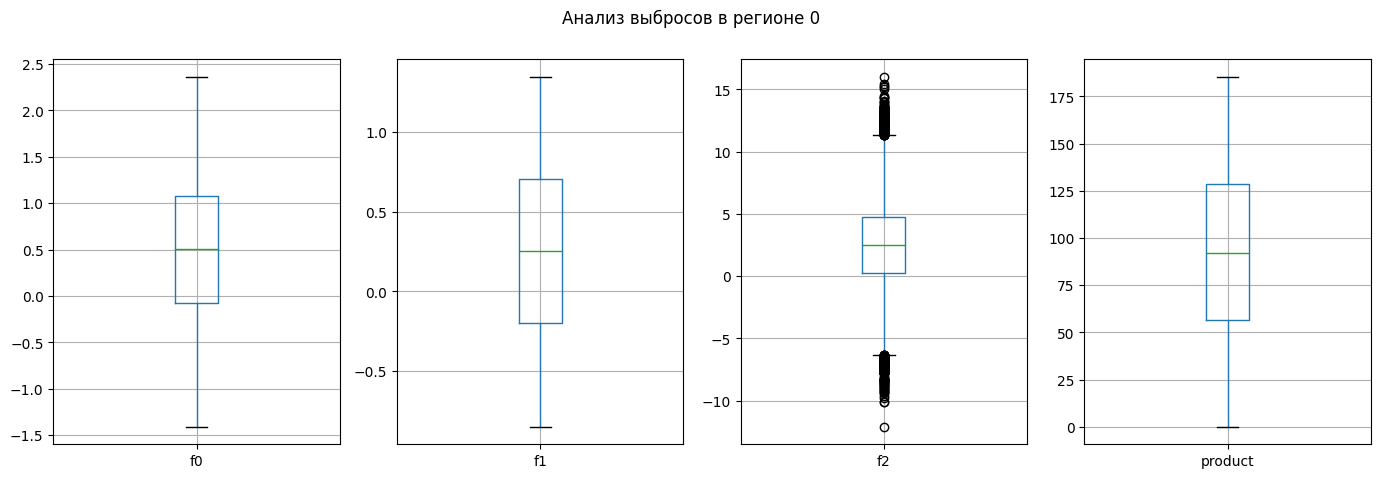

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(17, 5))

geo_data_0.boxplot('f0', ax=axes[0])
geo_data_0.boxplot('f1', ax=axes[1])
geo_data_0.boxplot('f2', ax=axes[2])
geo_data_0.boxplot('product', ax=axes[3])

fig.suptitle('Анализ выбросов в регионе 0')

plt.show()

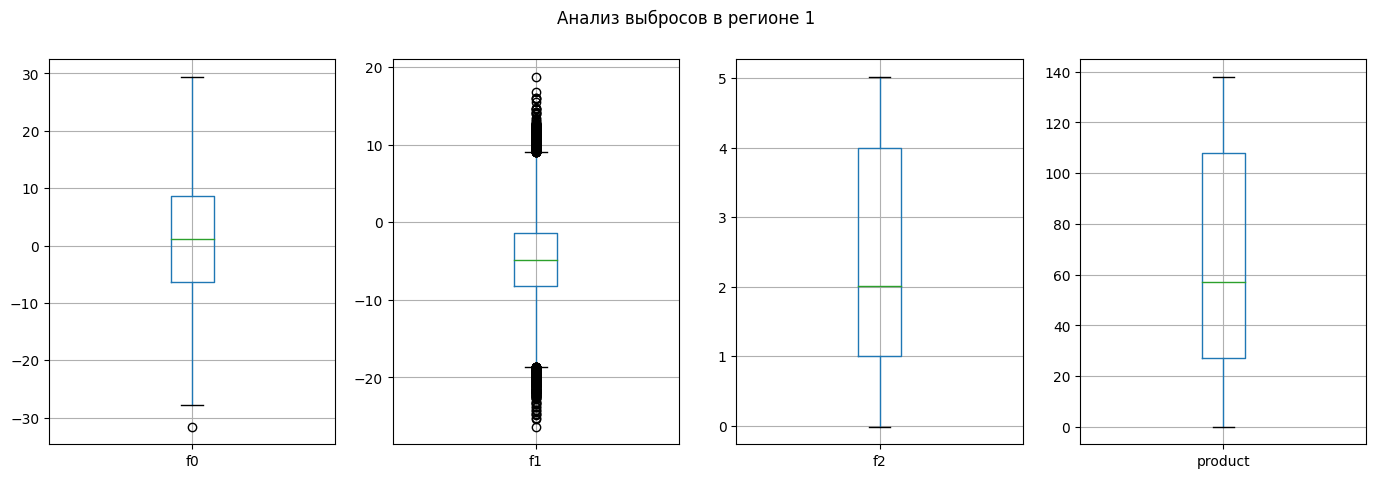

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(17, 5))

geo_data_1.boxplot('f0', ax=axes[0])
geo_data_1.boxplot('f1', ax=axes[1])
geo_data_1.boxplot('f2', ax=axes[2])
geo_data_1.boxplot('product', ax=axes[3])

fig.suptitle('Анализ выбросов в регионе 1')

plt.show()

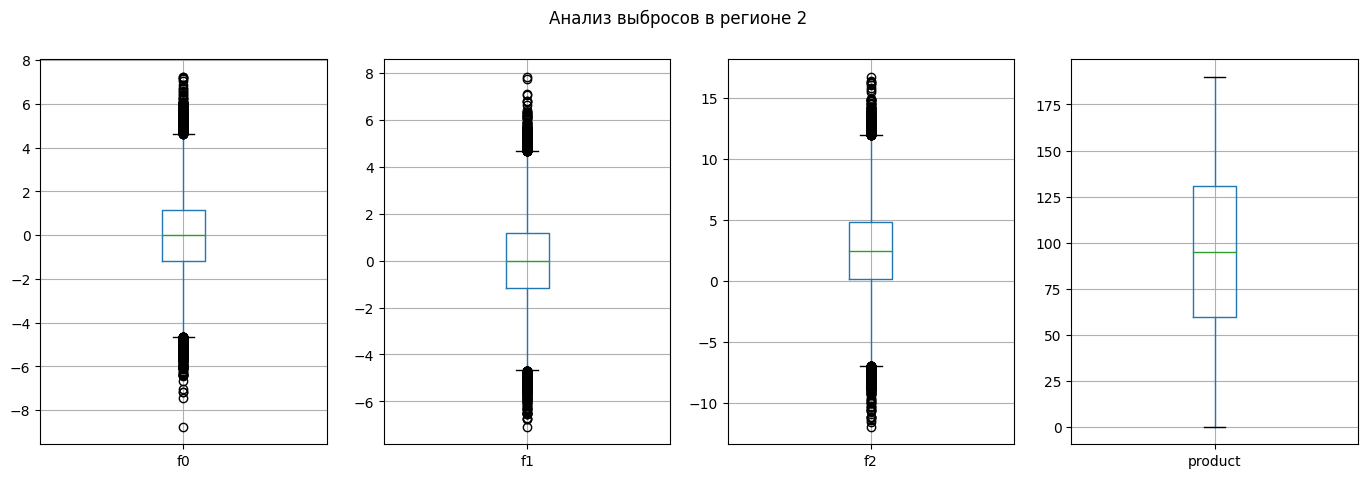

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(17, 5))

geo_data_2.boxplot('f0', ax=axes[0])
geo_data_2.boxplot('f1', ax=axes[1])
geo_data_2.boxplot('f2', ax=axes[2])
geo_data_2.boxplot('product', ax=axes[3])

fig.suptitle('Анализ выбросов в регионе 2')

plt.show()

## Обучение и проверка модели

[к навигации](#Навигация)

In [13]:
X_0 = geo_data_0.drop(columns='product')
y_0 = geo_data_0['product']

In [14]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
    X_0, y_0,
    random_state=RANDOM_STATE,
)

In [15]:
model_0 = LinearRegression()
model_0.fit(X_train_0, y_train_0)
y_pred_0 = model_0.predict(X_valid_0)
y_pred_0 = pd.Series(y_pred_0, index=X_valid_0.index)
print(
    f'Средний запас предсказанного сырья: {y_pred_0.mean()}.\n'
    f'RMSE: {mean_squared_error(y_valid_0, y_pred_0) ** .5}.'
)

Средний запас предсказанного сырья: 92.39879990657768.
RMSE: 37.75660035026169.


---

In [16]:
X_1 = geo_data_1.drop(columns='product')
y_1 = geo_data_1['product']

In [17]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    X_1, y_1,
    random_state=RANDOM_STATE,
)

In [18]:
model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1)
y_pred_1 = model_1.predict(X_valid_1)
y_pred_1 = pd.Series(y_pred_1, index=X_valid_1.index)
print(
    f'Средний запас предсказанного сырья: {y_pred_1.mean()}.\n'
    f'RMSE: {mean_squared_error(y_valid_1, y_pred_1) ** .5}.'
)

Средний запас предсказанного сырья: 68.71287803913762.
RMSE: 0.8902801001028858.


---

In [19]:
X_2 = geo_data_2.drop(columns='product')
y_2 = geo_data_2['product']

In [20]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    X_2, y_2,
    random_state=RANDOM_STATE,
)

In [21]:
model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)
y_pred_2 = model_2.predict(X_valid_2)
y_pred_2 = pd.Series(y_pred_2, index=X_valid_2.index)
print(
    f'Средний запас предсказанного сырья: {y_pred_2.mean()}.\n'
    f'RMSE: {mean_squared_error(y_valid_2, y_pred_2) ** .5}.'
)

Средний запас предсказанного сырья: 94.77102387765939.
RMSE: 40.145872311342174.


Да будто предсказания не плохи: mean очень схож с действительным, std тоже ...

## Подготовка к расчёту прибыли

[к навигации](#Навигация)

In [22]:
BUDGET = 10_000_000_000  # бюджет, выделенный на разработку скважин
PRICE = 450_000  # доход за продажу с единицы продукта
N = 200  # количество скважин для разработки

n = (BUDGET / N) / PRICE
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {n}.')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111.


In [23]:
print(
    f'Средний запас сырья в скважинах региона 0: {geo_data_0["product"].mean()}.\n'
    f'Средний запас сырья в скважинах региона 1: {geo_data_1["product"].mean()}.\n'
    f'Средний запас сырья в скважинах региона 2: {geo_data_2["product"].mean()}.'
)

Средний запас сырья в скважинах региона 0: 92.50000000000001.
Средний запас сырья в скважинах региона 1: 68.82500000000002.
Средний запас сырья в скважинах региона 2: 95.00000000000004.


Да, случайным образом выбирать скважины точно нельзя)

## Расчёт прибыли и рисков

[к навигации](#Навигация)

In [24]:
def profit(y_true, y_pred, count):
    y_pred = pd.Series(y_pred)
    y_true = pd.Series(y_true)
    sorted_pred = y_pred.sort_values(ascending=False)
    selected_true = y_true[sorted_pred.index][:count]

    return selected_true.sum() * PRICE - BUDGET

In [25]:
SUBSAMPLE_NUM = 1000  # количество подвыборок
SUBSAMPLE_SIZE = 500  # размер подвыборки
CHOICE_NUM = 200  # количество выбранных для разработки месторождений

state = np.random.RandomState(RANDOM_STATE)


def get_profits(y_valid, y_pred):
    profits = []
    for i in range(SUBSAMPLE_NUM):
        y_valid_subsample = y_valid.sample(n=SUBSAMPLE_SIZE, replace=True, random_state=state)
        y_pred_subsample = y_pred[y_valid_subsample.index]

        profits.append(profit(y_valid_subsample, y_pred_subsample, CHOICE_NUM))
    
    return pd.Series(profits)

In [26]:
profits_0 = get_profits(y_valid_0, y_pred_0)
profits_1 = get_profits(y_valid_1, y_pred_1)
profits_2 = get_profits(y_valid_2, y_pred_2)

In [27]:
mean_profit_0 = profits_0.mean()
mean_profit_1 = profits_1.mean()
mean_profit_2 = profits_2.mean()
print(
    f'Средняя прибыль в регионе 0 {round(mean_profit_0, 2)} рублей (~{round(mean_profit_0 / 1e6, 2)} миллионов рублей).\n'
    f'Средняя прибыль в регионе 1 {round(mean_profit_1, 2)} рублей (~{round(mean_profit_1 / 1e6, 2)} миллионов рублей).\n'
    f'Средняя прибыль в регионе 2 {round(mean_profit_2, 2)} рублей (~{round(mean_profit_2 / 1e6, 2)} миллионов рублей).'
)

Средняя прибыль в регионе 0 427847560.46 рублей (~427.85 миллионов рублей).
Средняя прибыль в регионе 1 511530218.15 рублей (~511.53 миллионов рублей).
Средняя прибыль в регионе 2 408545681.21 рублей (~408.55 миллионов рублей).


Здорово! В среднем в каждом регионе мы можем получить прибыль. Взглянем на доверительные интервалы.

In [28]:
print(
    f'95% доверительный интервал для региона 0: ({profits_0.quantile(0.025):.2f}, {profits_0.quantile(0.975):.2f})\n'
    f'95% доверительный интервал для региона 1: ({profits_1.quantile(0.025):.2f}, {profits_1.quantile(0.975):.2f})\n'
    f'95% доверительный интервал для региона 2: ({profits_2.quantile(0.025):.2f}, {profits_2.quantile(0.975):.2f})'
)

95% доверительный интервал для региона 0: (-97249829.57, 954215192.71)
95% доверительный интервал для региона 1: (91700564.14, 921455668.33)
95% доверительный интервал для региона 2: (-120624872.94, 960859440.73)


Ага, только для региона 1 в доверительный интервал попадают только доходные суммы.

In [29]:
print(
    f'Риск убытков в регионе 0: {(profits_0 < 0).mean():.2%}.\n'
    f'Риск убытков в регионе 1: {(profits_1 < 0).mean():.2%}.\n'
    f'Риск убытков в регионе 2: {(profits_2 < 0).mean():.2%}.'
)

Риск убытков в регионе 0: 5.50%.
Риск убытков в регионе 1: 0.60%.
Риск убытков в регионе 2: 7.50%.


По риску убытков у региона 1 тоже самый низкий показатель. Я бы выбрал его!

## Общий вывод

[к навигации](#Навигация)

Мы построили для каждого региона модели, предсказывающие объём сырья в скважине. Далее на бутстреп выборках рассчитали
среднюю прибыль и вероятности убытков с рачётом выбора топ-500 скважин по предсказаниям наших моделей. По полученным
значениям выбрали наиболее коммерчески успешный регион.